In [1]:
import numpy as np
import pandas as pd
import subprocess as sp
import itertools as it
import sys, re, collections
import scipy as sc
import pgenlib as pg

In [2]:
%matplotlib inline
import matplotlib
matplotlib.use('agg')
from matplotlib import pyplot as plt

/home/ytanigaw/.conda/envs/pgenlib/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
def make_plot(x, y, title = None, xlabel = None, ylabel = None, filename = None):
    '''
    This function generates histogram of a vector x and save to file
    Inputs:
      x: data vector
      title:    title of the plot
      xlabel:   label on x-axis
      ylabel:   label on y-axis
      filename: name of the image file (if given, save to file)
    Returns:
      matlab plot object
    Side effect:
      save an image file if filename is given
    '''
    
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(x, y)
    
    if(xlabel != None):
        ax.set_xlabel(xlabel)
    if(ylabel != None):
        ax.set_ylabel(ylabel)
    if(title != None):
        ax.set_title(title)
    if(filename != None):
        fig.savefig(filename)


In [4]:
times_f = '/share/PI/mrivas/data/nanopore-wgs-consortium/poretools_time.12888051.stats'

In [5]:
#times_df = pd.read_csv(times_f, sep = '\t', nrows=100)

In [6]:
times_df = pd.read_csv(times_f, sep = '\t')

In [7]:
times_df.head(10)

,channel,filename,read_length,exp_starttime,unix_timestamp,duration,unix_timestamp_end,iso_timestamp,day,hour,minute
0,227,/scratch/PI/mrivas/data/NA12878-fast5/rel3/${c...,28487,1479463036,1479470596,72,1479470668,2016-11-18T04:03:16+0000,18,4,3
1,1,/scratch/PI/mrivas/data/NA12878-fast5/rel3/${c...,5739,1480343031,1480344462,12,1480344474,2016-11-28T06:47:42+0000,28,6,47
2,477,/scratch/PI/mrivas/data/NA12878-fast5/rel3/${c...,1321,1481397870,1481398019,3,1481398022,2016-12-10T11:26:59+0000,10,11,26
3,340,/scratch/PI/mrivas/data/NA12878-fast5/rel3/${c...,1041,1476491635,1476501629,2,1476501631,2016-10-14T20:20:29+0000,14,20,20
4,36,/scratch/PI/mrivas/data/NA12878-fast5/rel3/${c...,13384,1479439380,1479440436,35,1479440471,2016-11-17T19:40:36+0000,17,19,40
5,410,/scratch/PI/mrivas/data/NA12878-fast5/rel3/${c...,4109,1480388539,1480402436,13,1480402449,2016-11-28T22:53:56+0000,28,22,53
6,49,/scratch/PI/mrivas/data/NA12878-fast5/rel3/${c...,5968,1476350077,1476351429,13,1476351442,2016-10-13T02:37:09+0000,13,2,37
7,450,/scratch/PI/mrivas/data/NA12878-fast5/rel3/${c...,1639,1480484512,1480486455,61,1480486516,2016-11-29T22:14:15+0000,29,22,14
8,93,/scratch/PI/mrivas/data/NA12878-fast5/rel3/${c...,795,1479439380,1479497548,2,1479497550,2016-11-18T11:32:28+0000,18,11,32
9,507,/scratch/PI/mrivas/data/NA12878-fast5/rel3/${c...,4166,1476472140,1476477395,11,1476477406,2016-10-14T13:36:35+0000,14,13,36


In [8]:
times_df.shape

(402772, 11)

- This contains all the data from part 1-5 

## time = 0 is ambiguous: multiple 'exp_starttime's

In [9]:
len(set(times_df['exp_starttime']))

1134

In [10]:
times_df['filename'][:10].as_matrix().tolist()

['/scratch/PI/mrivas/data/NA12878-fast5/rel3/${chr}/${fn}//MinION2_20161118_FNFAB45332_MN20093_sequencing_run_Chip104_Genomic_R9_4_450bps_tune_80266_ch227_read404_strand.fast5',
 '/scratch/PI/mrivas/data/NA12878-fast5/rel3/${chr}/${fn}//LomanLabz_PC_20161128_FNFAF01253_MN17024_sequencing_run_20161128_Human_Qiagen_1D_R9_4_50330_ch1_read220_strand.fast5',
 '/scratch/PI/mrivas/data/NA12878-fast5/rel3/${chr}/${fn}//LomanLabz_PC_20161210_FNFAB49908_MN17024_sequencing_run_20161209_Human_Rapidv2_12222_ch477_read19_strand.fast5',
 '/scratch/PI/mrivas/data/NA12878-fast5/rel3/${chr}/${fn}//PLSP57501_20161015_FNFAB42205_MN16458_sequencing_run_Hum94_jt_28680_ch340_read1065_strand1.fast5',
 '/scratch/PI/mrivas/data/NA12878-fast5/rel3/${chr}/${fn}//makeson_PC_20161117_FNFAB44989_MN17284_sequencing_run_MA_470_R9_4_NA12878_11_17_16_64834_ch36_read155_strand.fast5',
 '/scratch/PI/mrivas/data/NA12878-fast5/rel3/${chr}/${fn}//PLSP61583_20161129_FNFAB49914_MN17048_sequencing_run_Hu_Nott_Bi_FC4_tune_39428_

## filter read by read length

In [11]:
threshold = 12500
times_df_filtered = times_df.ix[times_df['read_length'] >= threshold, :]

In [12]:
times_df_filtered.shape

(86405, 11)

## make a plot

In [21]:
chr_len = 63025520

In [26]:
def plot_wrapper(times_df, chr_len, filename, comment = ""):
    times_df['relative_end'] = times_df['unix_timestamp_end'] - times_df['exp_starttime']
    times_df_sorted = times_df.sort_values(by = ['relative_end'], ascending=[1])
    make_plot(times_df_sorted['relative_end'].as_matrix(), 
          1.0 * np.cumsum(times_df_sorted['read_length'].as_matrix()) / chr_len,
          title = 'Time vs. Total read length (chr20 {} reads{})'.format(times_df.shape[0], comment),
          xlabel = 'Time (unix_timestamp_end - exp_starttime) [sec]', 
          ylabel = 'Coverage (= Total read length / length of chromosome 20)', 
          filename = filename)

## plot without filter

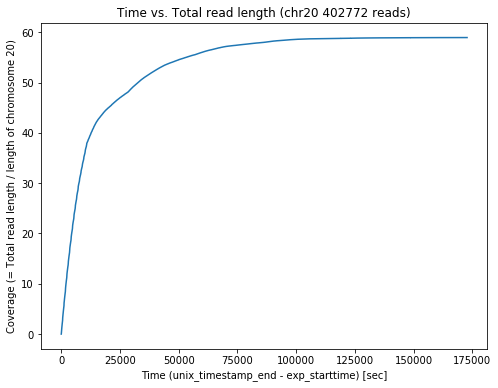

In [27]:
plot_wrapper(times_df=times_df, chr_len=chr_len, filename = '20170219_Time_vs_Total_read_length_plot.png')

## plot with read-length filter

/home/ytanigaw/.conda/envs/pgenlib/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


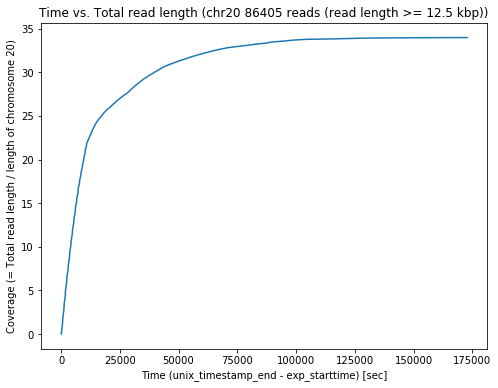

In [28]:
plot_wrapper(times_df=times_df_filtered, chr_len=chr_len, comment = " (read length >= 12.5 kbp)",
            filename = '20170219_Time_vs_Total_read_length_plot.geq12500.png')